In [2]:
import ast
import torch
torch.cuda.current_device()

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils.misc_utils import check_create_folder


from prediction.evaluation import compute_rNMSEs_per_step, compute_iteration_rNMSE, perform_chunk_predictions, rNMSE
from prediction.pred_utils import get_device, transform_data_to_all_steps_prediction, get_name_string, get_NOAA_dataset

from prediction.NOAA.difference_utils import perform_step_ahead_deltas, invert_difference_graph_signals, \
compute_iteration_rNMSE_with_deltas, visualize_predictions, visualize_deltas

from architectures.space_time.parametric_pooling_net_ordering import ParametricNetWithPoolingOrdered

from utils.graph_utils import permutation_by_degree

device = get_device(use_gpu=True)

Device selected: cuda:0


# --------------------------------------------------------------------------------------

In [3]:
BEST = True
# runs_dir = "C:\\Users\\gabri\\Desktop\\exp_prediction_NOAA\\diff_24_february_2020\\"
runs_dir = "C:\\Users\\gabri\\Desktop\\new_thesis_project\\prediction\\NOAA\\runs_NOAA_w=4_diff=True\\"
model_name = "20200228083841_lr=0.01_b=256_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 76]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True"
model_path = runs_dir + model_name

cyclic = 'cyclic=True' in model_name
time_directed = 'tdirect=False' not in model_name


print(f"Cyclic: {cyclic}")
print(f"Time directed: {time_directed}")
print(f"Best: {BEST}")

Cyclic: True
Time directed: True
Best: True


# --------------------------------------------------------------------------------------

# Loading the data

We need both the original dataset (obtained after removing the in-sample mean) and the dataset obtained after differencing the timesteps (first-order difference). In particular, we need:
- original dataset: we only need the labels, which we will be using to reconstruct the original signals
- differenced dataset: we will need
    - 1) the data (differenced), so that we can compute the actual predictions (deltas)
    - 2) the labels, so that we can plot the predicted Deltas against the true Deltas

In [4]:
ds_folder = "../"
splits = [0.35, 0.15, 0.5]
obs_window = 4

dataset_differences, steps_ahead, weighted_adjacency = get_NOAA_dataset(
    ds_folder,
    splits=splits,
    obs_window=obs_window,
    differenced=True,
)
trn_data_deltas, val_data_deltas, tst_data_deltas, trn_labels_deltas, val_labels_deltas, tst_labels_deltas = transform_data_to_all_steps_prediction(dataset_differences, node_first=True, device=device)
N_spatial_nodes = weighted_adjacency.shape[0]

orig_dataset, _, _ = get_NOAA_dataset(
    ds_folder,
    splits=splits,
    obs_window=obs_window,
    differenced=False,
)
_, _, _, orig_trn_labels, orig_val_labels, orig_tst_labels = transform_data_to_all_steps_prediction(orig_dataset, node_first=True, device=device)
assert orig_tst_labels.shape[0] == tst_labels_deltas.shape[0] + 1

print(f"{N_spatial_nodes} nodes - {obs_window} observed timesteps - steps ahead: {steps_ahead}\n\n")


print("Deltas trn data shape: ", trn_data_deltas.shape)
print("Deltas val data shape: ", val_data_deltas.shape)
print("Deltas tst data shape: ", tst_data_deltas.shape)

print("\nDeltas test labels shape: ", tst_labels_deltas.shape)


print("\nOriginal trn labels shape: ", orig_trn_labels.shape)
print("Original val labels shape: ", orig_val_labels.shape)
print("Original tst labels shape: ", orig_tst_labels.shape)





NOAA is selected



Dataset path: ..//NOAA/dataset/processed/NOA_w=4_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5]_differenced.pickle


NOAA is selected



Dataset path: ..//NOAA/dataset/processed/NOA_w=4_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5].pickle
109 nodes - 4 observed timesteps - steps ahead: [1, 2, 3, 4, 5]


Deltas trn data shape:  torch.Size([3057, 1, 109, 4])
Deltas val data shape:  torch.Size([1306, 1, 109, 4])
Deltas tst data shape:  torch.Size([4371, 1, 109, 4])

Deltas test labels shape:  torch.Size([4371, 5, 109])

Original trn labels shape:  torch.Size([3057, 5, 109])
Original val labels shape:  torch.Size([1306, 5, 109])
Original tst labels shape:  torch.Size([4372, 5, 109])


# --------------------------------------------------------------------------------------
# Create the model
This must match the model we are going to load from the checkpoint

In [5]:
start = 5

features = ast.literal_eval(model_name.split("_")[start].split("=")[1])
taps = ast.literal_eval(model_name.split("_")[start+1].split("=")[1])
pool_ratios = ast.literal_eval(model_name.split("_")[start+2].split("=")[1])
reach = ast.literal_eval(model_name.split("_")[start+3].split("=")[1])
nodes = ast.literal_eval(model_name.split("_")[start+4].split("=")[1])

for elem in [features, taps, pool_ratios, reach, nodes]:
    print(elem)

[4, 12]
[2, 2]
[2, 2]
[1, 1]
[109, 76]


In [6]:
feat_per_layer = [1] + features
taps_per_layer = taps
pool_reach_per_layer = reach
active_nodes_per_timestep_per_layer = [N_spatial_nodes] + nodes
time_pooling_ratio_per_layer = pool_ratios



one_step_gtcnn = ParametricNetWithPoolingOrdered(
    window=obs_window,
    cyclic_time_graph=cyclic,
    time_directed=time_directed,
    S_spatial=weighted_adjacency,
    n_feat_per_layer=feat_per_layer,
    n_taps_per_layer=taps_per_layer,
    n_active_nodes_per_timestep_per_layer=active_nodes_per_timestep_per_layer,
    time_pooling_ratio_per_layer=time_pooling_ratio_per_layer,
    pool_reach_per_layer=pool_reach_per_layer,
    output_dim=N_spatial_nodes,
    device=device)

one_step_gtcnn = one_step_gtcnn.to(device)
#print(one_step_gtcnn)

model_parameters = filter(lambda p: p.requires_grad, one_step_gtcnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

Initialization (random) with gain 0.2
Initialization (random) with gain 0.2
Number of parameters: 99645


# Load the model

In [7]:
naming = "best" if BEST else "last"
checkpoint = torch.load(f"{model_path}/{naming}_one_step_gtcnn.pth") 

one_step_gtcnn.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

one_step_gtcnn.eval()
print(f"{naming} model was at epoch: {epoch}")

best model was at epoch: 182


### Let's compute the delta predictions up to the fifth step ahead as well as the cumulative deltas
The idea is that our model is only able to predict differences: the estimate value at time t+4 will be the observed value at time t plus the 4 estimated deltas (the cumulative delta at 4 step-ahead)

In [8]:
tst_data_deltas = tst_data_deltas.float()
delta_predictions_dict_tst, cumulative_delta_predictions_dict_tst = perform_step_ahead_deltas(tst_data_deltas, one_step_gtcnn, steps_ahead, verbose=True)

Computing delta predictions for 1-step ahead.
Computing delta predictions for 2-step ahead.
Computing delta predictions for 3-step ahead.
Computing delta predictions for 4-step ahead.
Computing delta predictions for 5-step ahead.
Building cumulative step predictions for step 1
Summing deltas [1]
Building cumulative step predictions for step 2
Summing deltas [1, 2]
Building cumulative step predictions for step 3
Summing deltas [1, 2, 3]
Building cumulative step predictions for step 4
Summing deltas [1, 2, 3, 4]
Building cumulative step predictions for step 5
Summing deltas [1, 2, 3, 4, 5]


In [9]:
print(delta_predictions_dict_tst.keys())
print(delta_predictions_dict_tst[1].shape)

print(cumulative_delta_predictions_dict_tst.keys())
print(cumulative_delta_predictions_dict_tst[1].shape)

dict_keys([1, 2, 3, 4, 5])
torch.Size([4371, 109])
dict_keys([1, 2, 3, 4, 5])
torch.Size([4371, 109])


In [10]:
print(delta_predictions_dict_tst[1][:5, 60])
print(delta_predictions_dict_tst[2][:5, 60])
print(delta_predictions_dict_tst[1][:5, 60] + delta_predictions_dict_tst[2][:5, 60])
print(cumulative_delta_predictions_dict_tst[2][:5, 60])

tensor([-1.0464, -1.5885, -1.9930, -1.7465, -1.8553], device='cuda:0')
tensor([-2.0024, -2.0965, -1.7470, -1.1471, -1.2419], device='cuda:0')
tensor([-3.0488, -3.6850, -3.7400, -2.8936, -3.0973], device='cuda:0')
tensor([-3.0488, -3.6850, -3.7400, -2.8936, -3.0973])


## Finally, now we can compute the rNMSE for each step ahead

In [12]:
gtcnn_values_tst, persistence_values_tst = compute_iteration_rNMSE_with_deltas(
    cumulative_deltas_dict=cumulative_delta_predictions_dict_tst,
    original_one_step_labels=orig_tst_labels[:, 0, :].float(),
    verbose=False
)

In [14]:
print(gtcnn_values_tst)
print(persistence_values_tst)

[0.021, 0.0468, 0.0795, 0.1154, 0.1511]
[0.0964, 0.1875, 0.2715, 0.3476, 0.4154]


In [15]:
figure_dir = f"{runs_dir}..\\figures\\"
check_create_folder(figure_dir)
print(figure_dir)

C:\Users\gabri\Desktop\new_thesis_project\prediction\NOAA\runs_NOAA_w=4_diff=True\..\figures\


In [16]:
g_varma_rNMSEs = [0.0344, 0.0887, 0.1537, 0.2217, 0.2876]
gp_var_rNMSEs = [0.0402, 0.1013, 0.1730, 0.2487, 0.3246]
lstm_rNMSEs = [0.0268, 0.0545, 0.0895, 0.1353, 0.1863]

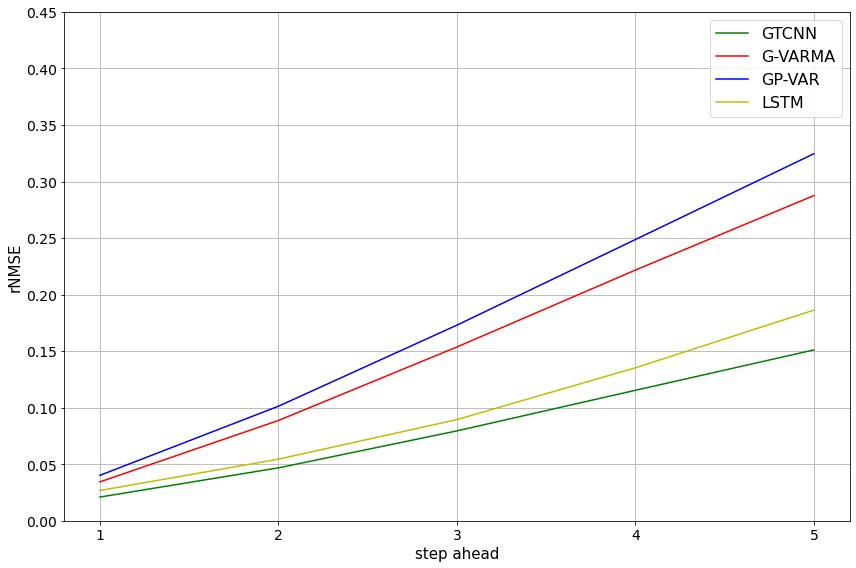

NOAA


In [17]:
from matplotlib.ticker import MaxNLocator



ax = plt.figure(figsize=(12, 8)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(steps_ahead, gtcnn_values_tst, 'g', label='GTCNN')
plt.plot(steps_ahead, g_varma_rNMSEs, 'r', label='G-VARMA')
plt.plot(steps_ahead, gp_var_rNMSEs, 'b', label='GP-VAR')
plt.plot(steps_ahead, lstm_rNMSEs, 'y', label='LSTM')
#plt.plot(steps_ahead, persistence_values_tst, 'y', label='Persistence')


plt.xlabel("step ahead", fontsize=15)
plt.ylabel("rNMSE", fontsize=15)
plt.legend(fontsize=16)
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.grid()
plt.ylim(0, 0.45)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# 
plt.tight_layout()
#plt.savefig(figure_dir + model_name + ".png")
plt.show()


print(model_path.split("_")[3])

## Note: the means have already beed subtracted since we use the 'non-differenced' data to restore the original signals. Since this data was generated WITHOUT the insample means, our computation of the rNMSE is the same as the paper of G-varma and GP-var

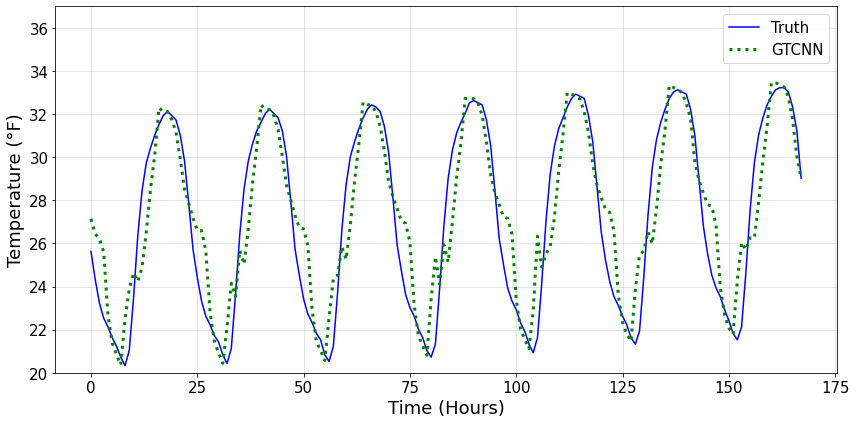

In [38]:
step_to_visualize = 5
start = 48
width = 24*7
node_to_visualize = 78

end = start + width
restored_predicted_values_gtcnn = invert_difference_graph_signals(
    orig_tst_labels[:, 0, :].cpu().float(),
    cumulative_delta_predictions_dict_tst[step_to_visualize].cpu().float(), 
    step_to_visualize)

matched_original_values = orig_tst_labels[:, 0, :][step_to_visualize:].cpu()

truth = matched_original_values[start:end, node_to_visualize]
gtcnn_pred = restored_predicted_values_gtcnn[start:end, node_to_visualize]

truth_style = '-'
pred_style = ':'
# plot of all_data
plt.figure(figsize=(12, 6))
plt.plot(range(width), truth, 'b', linestyle=truth_style, label='Truth')  # plotting t, a separately
plt.plot(range(width), gtcnn_pred, 'g', linestyle=pred_style, label='GTCNN', linewidth=3)  # plotting t, b separately

# title = f"Station {station_idx}: {station_names[station_idx]} ({station_num})"
plt.xlabel("Time (Hours)", fontsize=18)
plt.ylabel("Temperature (°F)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.4)
plt.legend(fontsize=15)

plt.ylim(20, 37)

plt.tight_layout()
plt.savefig(r"C:\Users\gabri\Desktop" + f"\_step{step_to_visualize}_node{node_to_visualize}.pdf")

plt.show()

# Prediction Visualizations

In [ ]:
visualize_predictions(
    cumulative_delta_predictions_dict_tst, 
    orig_tst_labels[:, 0, :],
    start=500,
    width=24*7,
    node=78,
    type_of_data='Test'
)

# Deltas visualizations

In [ ]:
visualize_deltas(
    delta_predictions_dict_tst, 
    tst_labels_deltas,
    start=0,
    width=88,
    node=60,
    type_of_data='Test'
)

# Computing metrics on the three sets

### Training set

In [ ]:
delta_predictions_dict_trn, cumulative_delta_predictions_dict_trn = perform_step_ahead_deltas(trn_data_deltas, one_step_gtcnn, steps_ahead)
gtcnn_values_trn, persistence_values_trn = compute_iteration_rNMSE_with_deltas(
    cumulative_deltas_dict=cumulative_delta_predictions_dict_trn,
    original_one_step_labels=orig_trn_labels[:, 0, :],
)
print(gtcnn_values_trn)
print(persistence_values_trn)

### Validation set

In [ ]:
delta_predictions_dict_val, cumulative_delta_predictions_dict_val = perform_step_ahead_deltas(val_data_deltas, one_step_gtcnn, steps_ahead)
gtcnn_values_val, persistence_values_val = compute_iteration_rNMSE_with_deltas(
    cumulative_deltas_dict=cumulative_delta_predictions_dict_val,
    original_one_step_labels=orig_val_labels[:, 0, :],
)
print(gtcnn_values_val)
print(persistence_values_val)

# Results

In [ ]:
print(model_name)
print(f"\nTrain: \t{gtcnn_values_trn} \t| Avg: {round(np.average(gtcnn_values_trn), 4)} \t| Std: {round(np.std(gtcnn_values_trn), 4)}\n")
print(f"Val: \t{gtcnn_values_val} \t| Avg: {round(np.average(gtcnn_values_val), 4)} \t| Std: {round(np.std(gtcnn_values_val), 4)}\n")
print(f"Test: \t{gtcnn_values_tst} \t| Avg: {round(np.average(gtcnn_values_tst), 4)} \t| Std: {round(np.std(gtcnn_values_tst), 4)}\n")

# ---------------------------------------- log ----------------------------------------------
20200203172708_lr=0.01_b=128_w=4_L=2_F=[8, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[109, 54]_wd=0_cyclic=True_lambda=0_tdirect=True

Train: 	[0.0174, 0.0439, 0.0821, 0.1276, 0.1831] 	| Avg: 0.0908 	| Std: 0.0592

Val: 	[0.0195, 0.0436, 0.078, 0.1176, 0.1654] 	| Avg: 0.0848 	| Std: 0.0521

Test: 	[0.023, 0.0513, 0.0894, 0.1306, 0.1725] 	| Avg: 0.0934 	| Std: 0.0536

### ------------------------------------------------------------------------------------------------

(Very good looking predictions)

20200204150749_lr=0.01_b=128_w=4_L=2_F=[8, 6]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[109, 32]_wd=0_cyclic=True_lambda=0_tdirect=True

Train: 	[0.0135, 0.0328, 0.062, 0.094, 0.1268] 	| Avg: 0.0658 	| Std: 0.0409

Val: 	[0.0173, 0.0328, 0.0474, 0.0654, 0.0905] 	| Avg: 0.0507 	| Std: 0.0255

Test: 	[0.0231, 0.0577, 0.1058, 0.1548, 0.1954] 	| Avg: 0.1074 	| Std: 0.0626


### ------------------------------------------------------------------------------------------------



# ------------------------------------------------------------------------------------------------

# Other visualizations

In [ ]:
visualize_predictions(
    cumulative_delta_predictions_dict_trn, 
    orig_trn_labels[:, 0, :],
    start=0,
    width=88,
    node=60,
    type_of_data='Training'
)

In [ ]:
visualize_predictions(
    cumulative_delta_predictions_dict_val, 
    orig_val_labels[:, 0, :],
    start=0,
    width=88,
    node=60,
    type_of_data='Validation'
)

In [ ]:
visualize_deltas(
    delta_predictions_dict_trn, 
    trn_labels_deltas,
    start=0,
    width=88,
    node=60,
    type_of_data='Training'
)

In [ ]:
visualize_deltas(
    delta_predictions_dict_val, 
    val_labels_deltas,
    start=0,
    width=88,
    node=60,
    type_of_data='Validation'
)

In [ ]:
from matplotlib.ticker import MaxNLocator



ax = plt.figure(figsize=(12, 8)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

linewidth=2.5

plt.plot(steps_ahead, gtcnn_values_tst, 'g', label='GTCNN', linewidth=linewidth)
plt.plot(steps_ahead, g_varma_rNMSEs, 'r', label='G-VARMA', linewidth=linewidth)
plt.plot(steps_ahead, gp_var_rNMSEs, 'b', label='GP-VAR', linewidth=linewidth)
plt.plot(steps_ahead, lstm_rNMSEs, 'y', label='LSTM', linewidth=linewidth)

fontsize=25
ticksize=25
plt.xlabel("step ahead", fontsize=fontsize)
plt.ylabel("rNMSE", fontsize=fontsize)
plt.legend(fontsize=fontsize)
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.grid()
plt.ylim(0, 0.35)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

plt.tight_layout()
plt.savefig("C:\\Users\\gabri\\Desktop\\noaa.png")
plt.show()

print(model_path.split("_")[3])